**<div align="center"><span style="font-size:4em">Lösung</span></div>**

# Electric Vehicle Routing Problem 1 -- Zielfunktion und Datenstruktur

Website des Wettbewerbs: https://mavrovouniotis.github.io/EVRPcompetition2020/

Problembeschreibung: https://mavrovouniotis.github.io/EVRPcompetition2020/TR-EVRP-Competition.pdf


Wenn Sie den Code in colab ausführen, dann müssen Sie **nichts** weiter tun: Data und Helfercode werden automatisch herunter geladen. Wenn Sie auf Ihrem eigenen Laptop arbeiten, laden Sie Daten und Helfercode unter 
* Daten: https://mavrovouniotis.github.io/EVRPcompetition2020/evrp-benchmark-set.zip
* Helfercode: https://raw.githubusercontent.com/henningbruhn/mobp/main/vrp_aufgabe/evrp.py

herunter, entpacken Sie die Daten und speichern Sie die Daten in einem Verzeichnis namens <code>data</code>. Das Verzeichnis <code>data</code> sowie <code>evrp.py</code> müssen im gleichen Verzeichnis wie dieses Notebook liegen. Kommentieren Sie schließlich die markierten Zeilen in der nächsten Zelle aus.

In [1]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import time

path="data"

#### Wenn Sie den Code auf dem eigenen Laptop ausführen, kommentieren Sie die folgenden Zeilen aus ####
# download visualisation and helper code
!wget -q https://raw.githubusercontent.com/henningbruhn/mobp/main/vrp_aufgabe/evrp.py

# download and unpack instance data
!wget -q https://mavrovouniotis.github.io/EVRPcompetition2020/evrp-benchmark-set.zip
!unzip -qo evrp-benchmark-set.zip -d data
#### Ende auskommentieren ####

import evrp

Wir lesen die Instanzen ein und lassen uns die Namen der Instanzen ausgeben.

In [2]:
instances=evrp.read_in_all_instances(path)
for key in instances.keys():
    print("{:12} -> {:4} Kunden".format(key,instances[key].num_customers))

X-n573-k30   ->  573 Kunden
X-n749-k98   ->  749 Kunden
X-n1001-k43  -> 1001 Kunden
X-n214-k11   ->  214 Kunden
X-n143-k7    ->  143 Kunden
X-n819-k171  ->  819 Kunden
E-n101-k8    ->  101 Kunden
X-n916-k207  ->  916 Kunden
E-n23-k3     ->   23 Kunden
E-n51-k5     ->   51 Kunden
X-n351-k40   ->  351 Kunden
E-n33-k4     ->   33 Kunden
E-n76-k7     ->   76 Kunden
E-n30-k3     ->   30 Kunden
X-n685-k75   ->  685 Kunden
X-n459-k26   ->  459 Kunden
E-n22-k4     ->   22 Kunden


Wir picken uns eine der kleinen Instanzen heraus und lassen uns die Instanz anzeigen.

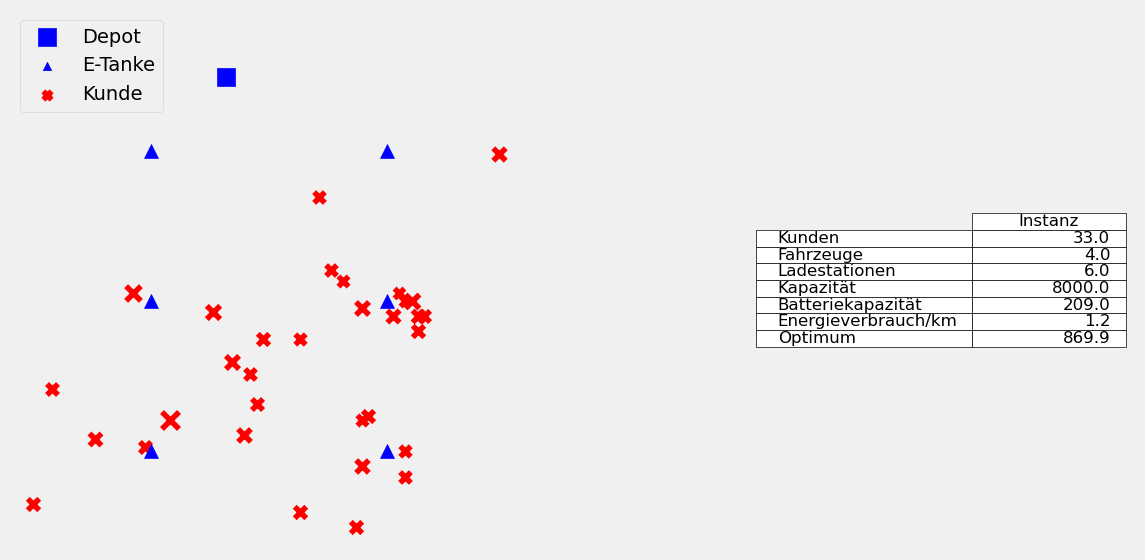

In [3]:
inst=instances['E-n33-k4']
evrp.show(inst)

Das <code>inst</code>-Objekt speichert alle Daten der Instanz. Insbesondere verfügt es über Listen <code>customers</code> und <code>stations</code>. Die Kunden und Ladestationen sind einfach durchnummeriert. Das Depot trägt die Nummer 1 und gilt ebenfalls als Ladestation.

In [4]:
print("ersten 10 Kunden: {}".format(inst.customers[:10]))
print("Ladestationen   : {}".format(inst.stations))

ersten 10 Kunden: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Ladestationen   : [34, 35, 36, 37, 38, 39, 1]


Wir können uns die 2d-Koordinaten jedes Kunden und jeder Station wie folgt ausgeben lassen (hier Station 37):

In [5]:
inst.nodes[37]

(318, 398)

Wir lassen uns alle Attribute des Instanzobjekts anzeigen:

In [6]:
print(inst)

instance
 .name=              E-n33-k4
 .num_customers=     33
 .num_stations=      7
 .capacity=          8000
 .energy_capacity=   209
 .energy_consumption=1.2
 .depot=             1
 .customers=         [1, 2, 3, 4, 5, 6, 7, 8, ,...]
 .demands=           {1: 0, 2: 700, 3: 400, 4:,...}
 .stations=          [34, 35, 36, 37, 38, 39, 1]
 .nodes=             {1: (292, 495), 2: (298, ,...}
 .optimum=           869.892175



## Exploration der Daten

Bei jeder datengetriebenen Fragestellung ist es unerlässlich, sich ein Überblick über die Daten zu verschaffen. Oben haben wir uns schon die Anzahl der Kunden pro Instanz auflisten lassen. Das ist sinnvoll, da wir so eine erste Idee der Schwere der Aufgabe erhalten. Welche weitere Kennzahlen sollten wir erheben? Hier sind zwei Vorschläge:
* die durchschnittliche Anzahl an Kunden pro Tour (dh, pro Fahrzeug)
* die Mindestzahl an benötigten Fahrzeuge und die tatsächlich vorhandene Anzahl

Wie können wir die Mindestzahl abschätzen? Wir rechnen die Gesamtsumme des Bedarfs der Kunden zusammen und teilen durch die Kapazität des Fahrzeuge.

Noch ein Tipp: Wenn Sie über die Instanzen iterieren wollen, können Sie dies so machen:

```
for instance in instances.values():
  ...do something
```

Erheben Sie sinnvolle Kennzahlen!

Wir berechnen zunächst die durchschnittliche Anzahl an Kunden pro Tour:

In [7]:
print("durchschnittliche Anzahl an Kunden pro Tour")
print("Kundenanzahl / Fahrzeuganzahl = Durchschnitt")
for instance in instances.values():
    num_customers=instance.num_customers
    vehicles=instance.vehicles
    print("{:4} / {:3} = {:5.2f}".format(num_customers,vehicles,num_customers/vehicles))

durchschnittliche Anzahl an Kunden pro Tour
Kundenanzahl / Fahrzeuganzahl = Durchschnitt
 573 /  30 = 19.10
 749 /  98 =  7.64
1001 /  43 = 23.28
 214 /  11 = 19.45
 143 /   7 = 20.43
 819 / 171 =  4.79
 101 /   8 = 12.62
 916 / 207 =  4.43
  23 /   3 =  7.67
  51 /   5 = 10.20
 351 /  40 =  8.78
  33 /   4 =  8.25
  76 /   7 = 10.86
  30 /   4 =  7.50
 685 /  75 =  9.13
 459 /  26 = 17.65
  22 /   4 =  5.50


Wir sehen die Zahl der Kunden schwankt zwischen 4 und etwa 20. 

Als nächstes vergleichen wir die Mindestanzahl an Fahrzeugen mit der tatsächlichen Zahl.

In [8]:
print("Mindestzahl an Fahrzeuge vs tatsächliche Anzahl")
for instance in instances.values():
    total_demand=sum(instance.demands.values())
    ratio=total_demand/instance.capacity
    print("{:6.1f} vs {:3}".format(ratio,instance.vehicles))

Mindestzahl an Fahrzeuge vs tatsächliche Anzahl
  29.4 vs  30
  97.0 vs  98
  42.4 vs  43
  11.0 vs  11
   6.3 vs   7
 170.2 vs 171
   7.3 vs   8
 206.5 vs 207
   2.3 vs   3
   4.9 vs   5
  39.7 vs  40
   3.7 vs   4
   6.2 vs   7
   2.8 vs   4
  74.3 vs  75
  25.7 vs  26
   3.8 vs   4


Wir sehen: Die Zahl der Fahrzeuge ist sehr knapp bemessen.

## Touren

Wie stellen wir eine Tour, also eine Lösung des Problems dar? Als Liste von Listen. Jedes Fahrzeug wird durch eine Liste repräsentiert, deren Einträge die angefahrenen Kunden bzw. Ladestationen widergeben. Gucken wir uns das mal an. Dazu erzeugen wir eine Zufallslösung mittels der Funktion <code>evrp.rnd_tour(instance, num_stations_insert=123)</code>. Dabei bestimmt der Parameter <code>num_stations_insert</code> wie viele Ladestation zufällig angefahren werden sollen.

In [9]:
random_tour=evrp.rnd_tour(inst,num_stations_insert=3)
random_tour

[[22],
 [],
 [10, 16, 17, 39, 18, 15, 7, 30, 26, 12, 19, 32, 24, 31, 2, 29],
 [33, 6, 11, 1, 21, 3, 25, 14, 28, 13, 36, 1, 27, 5, 8, 9, 4, 20, 23]]

Mit <code>evrp.tour_length(random_tour,inst)</code> können wir die Gesamtlänge der Tour bestimmen. Die Funktion <code>evrp.show</code> kann auch die Tour visualisieren.

Gesamtlänge der Touren: 2079.1
Reichweite überschritten!
Ladung 14630 übersteigt maximale Ladung von 8000!


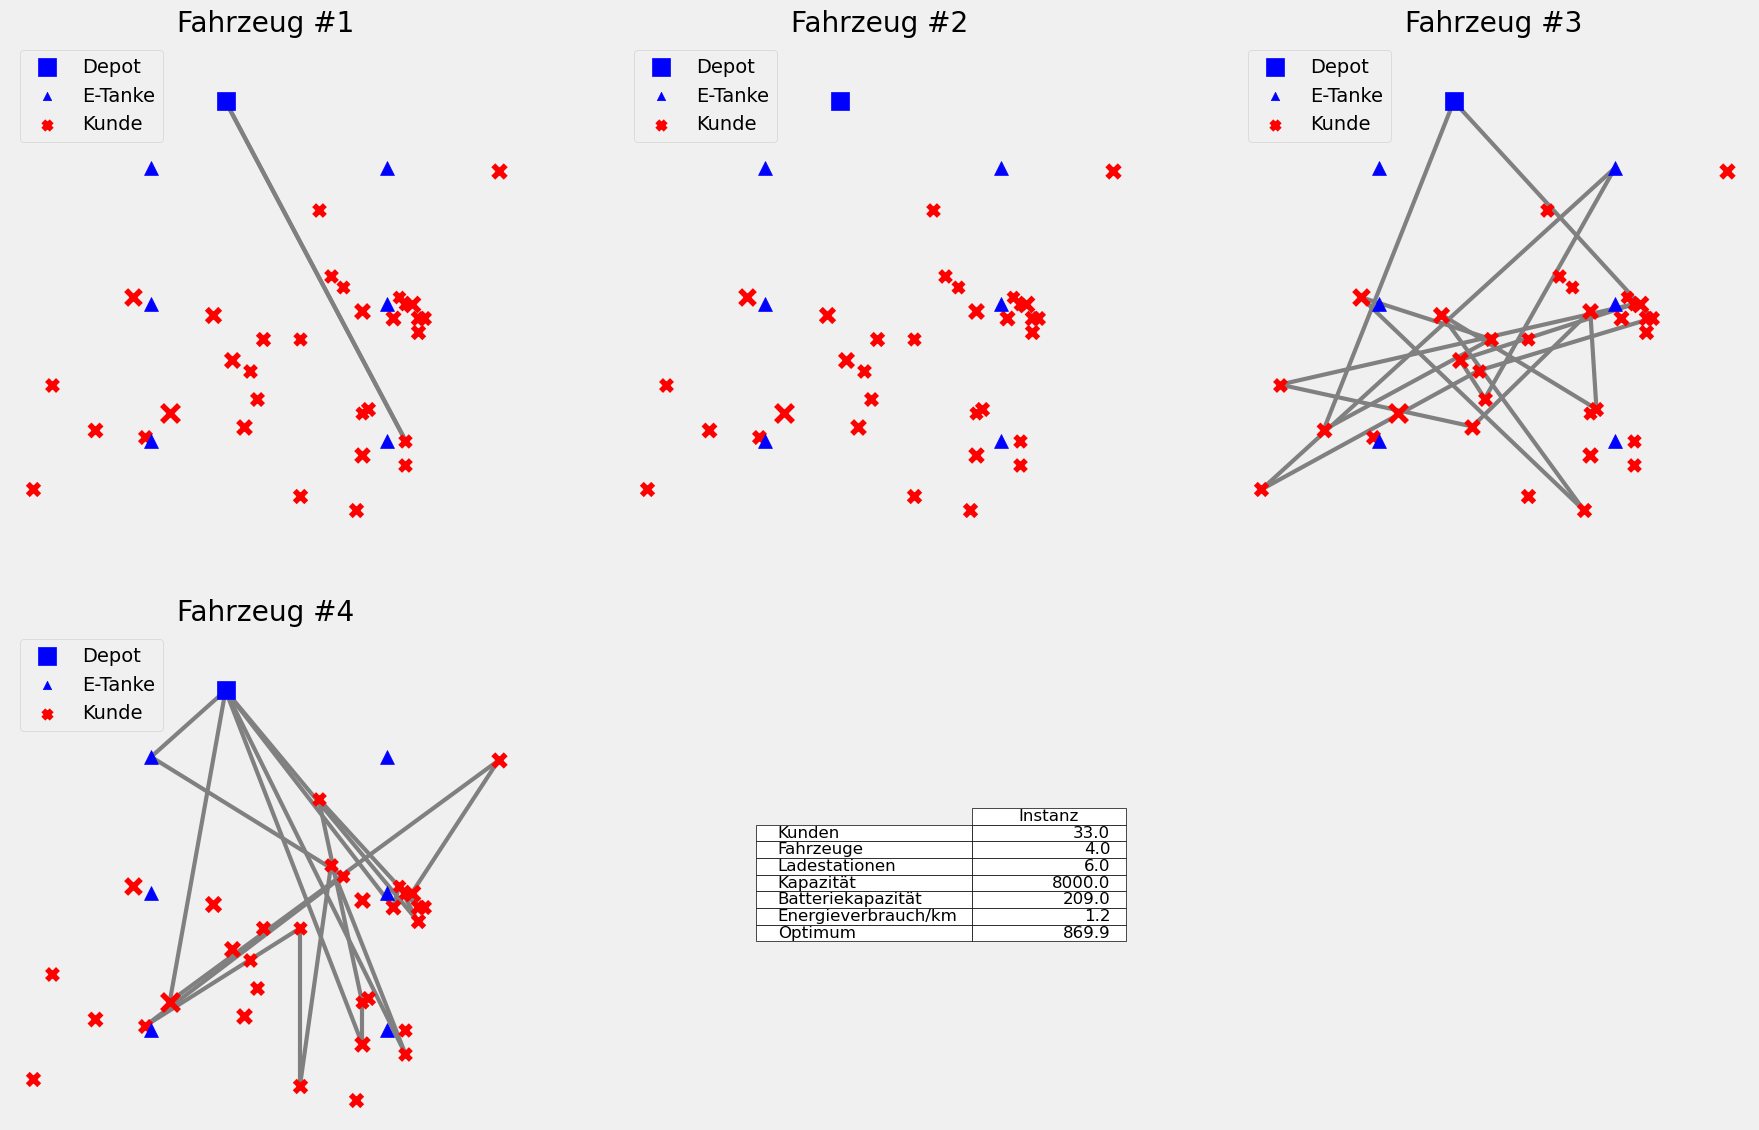

In [10]:
length=evrp.tour_length(random_tour,inst)
print("Gesamtlänge der Touren: {:.1f}".format(length))
evrp.show(inst,tour=random_tour)

Wir sehen: Die Zufallslösung ist nicht zulässig. Vielleicht war das einfach nur Pech? Erzeugen Sie 1000 Zufallstouren und bestimmen Sie wie viele davon zulässig sind (also die Laderaum- und Batteriekapazität nicht überschreiten). Nutzen Sie dazu die Funktion <code>evrp.validate(tour,instance)</code>, die <code>True</code> zurück liefert, wenn <code>tour</code> zulässig ist. 

Ist die Erzeugung von Zufallslösungen vielversprechend um eine gute Lösungen zu produzieren?

In [11]:
repeats=1000

feasible_tours=0
for _ in range(repeats):
    random_tour=evrp.rnd_tour(inst,num_stations_insert=4)
    if evrp.validate(random_tour,inst):
        feasible_tours+=1

print("Von {} Zufallstouren waren {} zulässig!".format(repeats,feasible_tours))

Von 1000 Zufallstouren waren 0 zulässig!


## Zielfunktion

Unten sind drei Touren (Lösungen) bereit gestellt. Zwei davon sind nicht zulässig. Wenn wir die Qualität der Touren beurteilen wollen, also eine Zielfunktion aufstellen, so wird die zulässige Tour die höchste Qualität haben (kleinsten Zielfunktionswert). Wie aber unterscheiden wir die Qualität der beiden unzulässigen Touren? Stellen Sie eine Zielfunktion auf, die die drei Touren in eine sinnvolle Reihenfolge bringt. 

Nützlich dazu sind die folgenden Funktionen:
* <code>evrp.tour_length(tour,inst)</code>: Die Gesamtlänge der Tour.
* <code>evrp.compute_loads(tour,inst)</code>: Eine Liste mit einem Eintrag pro Fahrzeug; jeder Eintrag ist der Gesamtbedarf der Kunden, die dem Fahrzeug zugeordnet sind.
* <code>evrp.compute_charge_lvls(tour,inst)</code>: Eine Liste von Listen, gibt den Batterieladungsstand jedes Fahrzeugs bei jedem Kunden an. Negative Ladungsstände zeigen an, dass die Reichweite überschritten ist.

In [12]:
tour1=evrp.sample1()
tour2=evrp.sample2()
tour3=evrp.sample3()

Bestimmen wir welche Tour zulässig ist und wie die Gesamtlängen aussehen.

In [13]:
for i,tour in enumerate([tour1,tour2,tour3]): # ginge auch ohne enumerate
    print("*** tour{} ***".format(i+1))
    val=evrp.validate(tour,inst,quiet=False)
    print("Zulässig: {}".format(val))
    print("Gesamtlänge: {:.1f}".format(evrp.tour_length(tour,inst)))
    print("")

*** tour1 ***
Reichweite überschritten!
Ladung 11500 übersteigt maximale Ladung von 8000!
Zulässig: False
Gesamtlänge: 733.7

*** tour2 ***
Reichweite überschritten!
Zulässig: False
Gesamtlänge: 979.5

*** tour3 ***
Zulässig: True
Gesamtlänge: 913.8



Gucken wir uns mal die Maximalladungen an.

In [14]:
load_lvls=evrp.compute_loads(tour1,inst)
load_lvls

[6830, 0, 11500, 11040]

...und die Batterieladestände:

In [15]:
charge_lvls=evrp.compute_charge_lvls(tour1,inst)
charge_lvls

[[209,
  145.62681955274772,
  141.30015802219094,
  132.16123029515424,
  123.42509842801762,
  122.22509842801762,
  117.27737167727642,
  116.07737167727642,
  63.66058047445669,
  5.661959801202741],
 [209],
 [209,
  135.7606663055978,
  123.00449133031621,
  115.80449133031621,
  61.80449133031621,
  49.98586196816089,
  31.668656941192395,
  23.268656941192397,
  19.668656941192395,
  202.21177490060916,
  187.81177490060915,
  186.11471862576144,
  159.76932054564125,
  154.67815172109812,
  125.7783247319966,
  56.209366136945036],
 [209,
  167.67397914146585,
  133.86037241281295,
  126.56105737645508,
  119.77283227706423,
  81.12985102561314,
  71.23439752413076,
  56.05546475532253,
  46.38075545736427,
  18.26385662410032,
  -5.403842883878905,
  -23.121630556158983,
  -125.96520108927496]]

Wir summieren die negativen Batterieladestände auf. Dies ist kumulativ. Dh, wenn wir beim zweiten Kunden einen Ladestand von -12 erreichen und beim dritten Kunden immer noch nicht geladen haben, also einen Ladestand von nun -30 haben, so summieren wir zu -42. Man könnte argumentieren, dass -30 das Defizit besser widergibt. 

Der Einfachheit halber multiplizieren wir die negative Ladestände mit -1.

In [16]:
def missing_charge(charge_lvls):
    missing=0
    return -sum([min(0,charge) for vehicle in charge_lvls for charge in vehicle])

test=[[-41,0,34],[100,23,-1,3]]
missing_charge(test)

42

Summieren wir ebenfalls die Überkapazität auf.

In [17]:
def over_capacity(loads,capacity):
    return sum([max(0,load-capacity) for load in loads])

test=[99,112,77,130]
over_capacity(test,100)

42

Damit können wir eine Zielfunktion aufstellen, in die das Überschreiten der Reichweite, das Überschreiten der Laderaumkapazität und die Gesamtlänge eingeht. Für weitere Flexibilität multiplizieren wir die beiden Strafterme mit einem Gewicht. Man könnte auch unterschiedliche Gewichte für die beiden Strafterme einführen. 

In [18]:
def objective_function(tour,inst,weight):
    length=evrp.tour_length(tour,inst)
    missing=missing_charge(evrp.compute_charge_lvls(tour,inst))
    over=over_capacity(evrp.compute_loads(tour,inst),inst.capacity)
    return length+weight*missing+weight*over

for i,tour in enumerate([tour1,tour2,tour3]): # ginge auch ohne enumerate
    print("*** tour{} ***".format(i+1))
    objective=objective_function(tour,inst,10000)
    print(" Zielfunktionswert: {:.1f}".format(objective))

*** tour1 ***
 Zielfunktionswert: 66945640.4
*** tour2 ***
 Zielfunktionswert: 1659544.1
*** tour3 ***
 Zielfunktionswert: 913.8
